# PATfix high-throughput data analysis: chromatogram visualization

## Some concepts first:
**Sequence**: is a list of entries containing details of the samples been analyzed on PATfix in a certian experiment. Usually the file will contain information such as name of the sample, location/well of where the sample is located in a plate (i.e. 96-well), concentration, the dilution factors, etc. Therefore, it is the metadata important for sample indexing and to link between different reports of the same experiment.

**Chromatogram**: is the visual output of a chromatography experiment, displaying how different components of a sample mixture separate over time. It helps identify and quantify molecules like proteins or metabolites based on their retention times and signal intensities. 

## User instructions
For this analysis, two datasets are required: the sequence/metadata and the chromatogram data.

## Initial preparations

### Prepare coding environment

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re 

### Look for source data files
Please organize all the data files, in .csv format, in one folder and save the folder in the same directory as this Jupyter notebook. Run the code chunk below and answer the prompted questions to identify the source data files.

In [6]:
# get current working directory
cwd = os.getcwd()
print(f"Current working directory: {cwd}")

# inquire the source data folder name
print ('\nPlease confirm the folder name where the source data is saved, data must be in .csv format and the folder must be in the same working directory as this jupyter notebook.')
folder_name = input()

folder_path = os.path.join(cwd,folder_name)
print(f'\nPath of the folder containing the data: {folder_path}')

Current working directory: /Users/zhouy25/Documents/GitHub/projects/dsa/examples/patfix_ht_ds

Please confirm the folder name where the source data is saved, data must be in .csv format and the folder must be in the same working directory as this jupyter notebook.


 example_data



Path of the folder containing the data: /Users/zhouy25/Documents/GitHub/projects/dsa/examples/patfix_ht_ds/example_data


In [8]:
# list all files in the data folder
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
print(f"\nAvailable files in folder '{folder_name}':{files}")

# inquire to specify the files containing the metadata and chromatogram data
print("\nWhich file contains the sequence/metadata? Only one file can be imported.")
metadata_file_name = input()

metadata_file_path = os.path.join(cwd,folder_name,metadata_file_name) # generate file path for the metadata


print("\nWhich file contains the chromatograms? Only one file can be imported.")
chromatogram_file_name = input()

chromatogram_file_path = os.path.join(cwd,folder_name,chromatogram_file_name) # generate file path for the metadata



Available files in folder 'example_data':['example1_sequence_metadata.csv', 'example1_chromatograms.csv']

Which file contains the sequence/metadata? Only one file can be imported.


 example1_sequence_metadata.csv



Which file contains the chromatograms? Only one file can be imported.


 example1_chromatograms.csv


### Organize the output directory

In [10]:
# Define the output folder name
output_folder = "output"

# Full path to the output folder
output_path = os.path.join(cwd, output_folder)

# Create the folder if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print(f"Created output folder: {output_path}")
else:
    print(f"Output folder already exists: {output_path}")


Output folder already exists: /Users/zhouy25/Documents/GitHub/projects/dsa/examples/patfix_ht_ds/output


## Metadata cleaning

In [12]:
"""Define a function to clean metadata"""

def load_and_clean_metadata(filepath): 
    
    """First extract column headers"""
    df_header = pd.read_csv(filepath, sep = '\t', header = None, nrows = 1)
    raw_header = df_header.iloc[0,0]
    headers = [col.strip('"\t\n') for col in raw_header.split('\t')]

    """Each row contains two fields/cells that stores all data, extract them and trim separators."""
    df_data = pd.read_csv(filepath, sep = '\t', header = None, skiprows = 1) # read-in the metadata
    df_data = df_data.map(lambda x: x.strip('""') if isinstance(x,str) else x) # strip "" from column 2 to 12

    """Column 1 is a bit different from the rest, some extra code for specific cleaning."""
    split_data = df_data.iloc[:,0].apply(lambda x: [s for s in str(x).split('"') if s.strip()]) # take column 1, split into two
    split_df = pd.DataFrame(split_data.tolist(), index = df_data.index)
    split_df.iloc[:, 0] = split_df.iloc[:, 0].apply(lambda x: x.strip('\t') if isinstance(x, str) else x)
    split_df.iloc[:, 1] = split_df.iloc[:, 1].apply(lambda x: x.strip(',') if isinstance(x, str) else x)
    
    df_cleaned = pd.concat([split_df, df_data.iloc[:, 1:]], axis = 1)
    df_cleaned.columns = range(df_cleaned.shape[1])

    """Join the two columns that are both part of Status"""
    df_cleaned.iloc[:, 2] = df_cleaned.iloc[:, 2].astype(str) + ' "' + df_cleaned.iloc[:, 3].astype(str) + '"'
    df_cleaned.drop(df_cleaned.columns[3], axis=1, inplace=True)
    df_cleaned.columns = range(df_cleaned.shape[1])
    
    """Assign header properly"""
    df_cleaned.columns = headers

    return df_cleaned


### Result

In [14]:
metadata_clean = load_and_clean_metadata(metadata_file_path)
metadata_clean.head()

,No,Status,Enabled,Sample ID,Sample description,Sample type,Method,Repeat,Vial no.,Inj. vol.,Dilution,Concentration,"Smp. vol."","
0,1,Partial success with warning,"finished on: 2025-04-16T12:56:51-04 ""Yes""",Blank,MPA,Blank,IVT monitoring - 96 well_2mmNeedleHeight (rev. 1),1,1.A.1,100,0,0,0
1,2,Successful,"finished on: 2025-04-16T13:05:25-04 ""Yes""",Blank 1,MPA,Blank,IVT monitoring - 96 well_2mmNeedleHeight (rev. 1),1,1.A.1,100,0,0,0
2,3,Successful,"finished on: 2025-04-16T13:14:00-04 ""Yes""",Blank 2,MPA,Blank,IVT monitoring - 96 well_2mmNeedleHeight (rev. 1),1,1.A.1,100,0,0,0
3,4,Successful,"finished on: 2025-04-16T13:15:25-04 ""Yes""",Stop,Stop,Blank,Stop method - 96 well_2mm Needle Height (rev. 2),1,1.A.1,50,0,0,0
4,5,Successful,"finished on: 2025-04-17T11:21:21-04 ""Yes""",Blank 3,MPA,Blank,IVT monitoring - 96 well_2mmNeedleHeight (rev. 1),3,1.A.1,100,0,0,0


### Export metadata to a .csv file

In [275]:
# Define filename
filename = "metadata_clean.csv"

# Ensure output folder exists (this is safe to run even if already created)
cwd = os.getcwd()
output_path = os.path.join(cwd, output_folder)
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Full file path
file_path = os.path.join(output_path, filename)

# Export the dataframe to CSV
metadata_clean.to_csv(file_path, index=False)  # index=False to not save row numbers

print(f"Metadata exported successfully to: {file_path}")


Metadata exported successfully to: /Users/zhouy25/Documents/GitHub/projects/dsa/examples/patfix_ht_ds/output/metadata_clean.csv


In [16]:
# Sample description is a critical index to bridge to chromatogram data
"""Creat a list of unique sample description names for later use"""
sample_description_unique = metadata_clean["Sample ID"].dropna().unique().tolist()
name_count = len(sample_description_unique)

print("\n Number of Sample IDs = ", name_count)


 Number of Sample IDs =  79


## Chromatogram data cleaning

### Load data

In [18]:
chromatogram_df = pd.read_csv(chromatogram_file_path, sep = ';')
chromatogram_df.head()

,Time[min],ATP_0.5uM.Absorbance 1 MWD 2.1L [mAU],ATP_0.5uM.Absorbance 2 MWD 2.1L [mAU],ATP_0.5uM.Composition A P 6.1L LPG [%],ATP_0.5uM.Conductivity CM 2.1S [mS/cm],ATP_0.5uM.Flow rate P 6.1L LPG [mL/min],ATP_0.5uM.pH CM 2.1S [],ATP_0.5uM.Pressure P 6.1L LPG [MPa],ATP_10uM.Absorbance 1 MWD 2.1L [mAU],ATP_10uM.Absorbance 2 MWD 2.1L [mAU],...,UTP_3uM.Flow rate P 6.1L LPG [mL/min],UTP_3uM.pH CM 2.1S [],UTP_3uM.Pressure P 6.1L LPG [MPa],UTP_5uM.Absorbance 1 MWD 2.1L [mAU],UTP_5uM.Absorbance 2 MWD 2.1L [mAU],UTP_5uM.Composition A P 6.1L LPG [%],UTP_5uM.Conductivity CM 2.1S [mS/cm],UTP_5uM.Flow rate P 6.1L LPG [mL/min],UTP_5uM.pH CM 2.1S [],UTP_5uM.Pressure P 6.1L LPG [MPa]
0,0.000,0.0200,0.0080,NaN,0.5523,NaN,6.88,NaN,0.0070,-0.0020,...,NaN,6.88,NaN,0.0090,0.0080,NaN,0.5470,NaN,6.88,NaN
1,0.008,-0.0023,-0.0028,100.0,0.5519,2.0,6.88,1.3440,0.0055,0.0033,...,2.0,6.88,1.4320,0.0045,0.0063,100.0,0.5465,2.0,6.88,1.3765
2,0.016,0.0119,0.0047,100.0,0.5516,2.0,6.88,1.2979,0.0098,0.0119,...,2.0,6.88,1.3774,0.0013,0.0175,100.0,0.5460,2.0,6.88,1.3857
3,0.024,0.0051,0.0055,100.0,0.5513,2.0,6.88,1.2379,0.0071,0.0156,...,2.0,6.88,1.2928,-0.0007,-0.0007,100.0,0.5456,2.0,6.88,1.3992
4,0.032,0.0083,-0.0024,100.0,0.5510,2.0,6.88,1.2935,-0.0036,0.0059,...,2.0,6.88,1.3136,-0.0051,0.0032,100.0,0.5451,2.0,6.88,1.3952


### Re-organize into a dictionary

In [28]:
"""The chromatogram data is a classic multi-sample, multi-signal time series dataset.
   Re-organize the dataset into a dictionary will make it easier to access."""

"""Extract the time column"""
time = chromatogram_df.iloc[:,0] 
time.name = 'Time[min]'

"""Re-organize the main body of the dataset into a dictionary"""
# Initialize dictionary
sample_dict = {}

# Loop over all signal columns (skip Time column at index 0)
for col in chromatogram_df.columns[1:]:
    matched_sample_id = None

    """Sample ID and signal name parser"""
    matched_sample_id = None
    longest_match_length = -1

    """Sample ID from metadata is used here. 
    This is where if same sample was run more than once, you can pick them out using re functions"""
    # FIRST: try to match sample_id with ' rep\d+' (space + repX), index " repX" was predefined by the PATfix software
    for sample_id in sample_description_unique:
        # Build a regex: sample_id + space + repX
        pattern = re.compile(re.escape(sample_id) + r' rep\d+')
        match = pattern.search(col)
        if match:
            matched_text = match.group()
            if len(matched_text) > longest_match_length:
                matched_sample_id = matched_text
                longest_match_length = len(matched_text)
    
    """Sample ID from metadata is used here.
    Only the exact sample ID is searched."""
    # SECOND: if no match with ' repX', match regular sample_id
    if matched_sample_id is None:
        for sample_id in sample_description_unique:
            if sample_id in col and len(sample_id) > longest_match_length:
                matched_sample_id = sample_id
                longest_match_length = len(sample_id)

    """If no sample ID can be found then the metadata
    and the chromatogram dataset is not matching""" 
    # If still no match, raise error
    if matched_sample_id is None:
        raise ValueError(f"No matching sample_id found for column: {col}")

    # Now safely remove only the matched sample_id from the column to get signal name
    signal_name = col.replace(matched_sample_id, '', 1)
    if signal_name.startswith('.'):
        signal_name = signal_name[1:]

    """Store data into the dictionary"""
    # Create nested dictionary if not exist
    if matched_sample_id not in sample_dict:
        sample_dict[matched_sample_id] = {}
    
    # Save the signal data
    sample_dict[matched_sample_id][signal_name] = chromatogram_df[col].values

"""Store Time[min] column separately"""
sample_dict['Time[min]'] = time.values

### Renaming signals

In [30]:
# Create a mapping to customize old signal names to new signal names
rename_mapping = {
    "Absorbance 1 MWD 2.1L [mAU]": "A260 [mAU]",
    "Absorbance 2 MWD 2.1L [mAU]": "A280 [mAU]",
    "Composition A P 6.1L LPG [%]": "MPA [%]",
    "Conductivity CM 2.1S [mS/cm]": "Conductivity [mS/cm]",
    "Flow rate P 6.1L LPG [mL/min]": "Flow rate [ml/min]",
    "pH CM 2.1S []": "pH",
    "Pressure P 6.1L LPG [MPa]": "Pressure [MPa]"
}

# Loop over all samples (skip 'Time[min]')
for sample_id in sample_dict:
    if sample_id == 'Time[min]':
        continue  # skip the Time[min] entry

    # Loop through each old-new signal name pair
    for old_signal_name, new_signal_name in rename_mapping.items():
        if old_signal_name in sample_dict[sample_id]:
            # Rename: move the value and remove the old key
            sample_dict[sample_id][new_signal_name] = sample_dict[sample_id].pop(old_signal_name)

### Ways to use the chromatogram dictionary

#### 1. List all sample IDs

In [32]:
"""List all sample_ids"""
# Get all sample_ids (excluding 'Time[min]')
sample_ids = [sample_id for sample_id in sample_dict.keys() if sample_id != 'Time[min]']

# Optional: sort them nicely
sample_ids = sorted(sample_ids)

# Display
print(sample_ids)

['ATP_0.5uM', 'ATP_10uM', 'ATP_1uM', 'ATP_20uM', 'ATP_3uM', 'ATP_5uM', 'Blank ', 'Blank  1', 'Blank  10', 'Blank  11', 'Blank  12', 'Blank  13', 'Blank  14', 'Blank  15', 'Blank  16', 'Blank  2', 'Blank  3', 'Blank  3 rep2', 'Blank  3 rep3', 'Blank  4', 'Blank  4 rep2', 'Blank  5', 'Blank  6', 'Blank  7', 'Blank  8', 'Blank  9', 'CTP_0.5uM', 'CTP_10uM', 'CTP_1uM', 'CTP_20uM', 'CTP_3uM', 'CTP_5uM', 'CleanCap_0.5uM', 'CleanCap_10uM', 'CleanCap_1uM', 'CleanCap_20uM', 'CleanCap_3uM', 'CleanCap_5uM', 'GTP_0.5uM', 'GTP_10uM', 'GTP_1uM', 'GTP_20uM', 'GTP_3uM', 'GTP_5uM', 'SST Sample', 'SST Sample 1', 'UTP:CTP = 30:70_10uM', 'UTP:CTP = 30:70_1uM', 'UTP:CTP = 30:70_20uM', 'UTP:CTP = 30:70_3uM', 'UTP:CTP = 30:70_5uM', 'UTP:CTP = 50:50_10uM', 'UTP:CTP = 50:50_1uM', 'UTP:CTP = 50:50_20uM', 'UTP:CTP = 50:50_3uM', 'UTP:CTP = 50:50_5uM', 'UTP:CTP = 70:30_10uM', 'UTP:CTP = 70:30_1uM', 'UTP:CTP = 70:30_20uM', 'UTP:CTP = 70:30_3uM', 'UTP:CTP = 70:30_5uM', 'UTP_0.5uM', 'UTP_10uM', 'UTP_1uM', 'UTP_20uM', 

#### 2.List all signal names

In [34]:
"""List all signal names"""
# Create a set to collect all unique signal names
all_signal_names = set()

# Loop over samples
for sample_id in sample_dict:
    if sample_id == 'Time[min]':
        continue  # Skip the time array

    # Add all signal names for this sample
    all_signal_names.update(sample_dict[sample_id].keys())

# Turn into a sorted list (optional)
all_signal_names = sorted(all_signal_names)

# Display
print(all_signal_names)

['A260 [mAU]', 'A280 [mAU]', 'Conductivity [mS/cm]', 'Flow rate [ml/min]', 'MPA [%]', 'Pressure [MPa]', 'pH']


#### 3. To get all signal names for one sample

In [36]:
# To get all signal names for one sample:
list(sample_dict['ATP_5uM'].keys())

['A260 [mAU]',
 'A280 [mAU]',
 'MPA [%]',
 'Conductivity [mS/cm]',
 'Flow rate [ml/min]',
 'pH',
 'Pressure [MPa]']

#### 4. To get one signal’s time series

In [175]:
# To get one signal’s time series:
sample_dict['ATP_5uM']['A260 [mAU]'][:5] # show only the first five datapoints

array([-0.013 , -0.019 , -0.0222, -0.0033, -0.0041])

#### 5. To get the shared time array (Time[min])

In [177]:
# To get the shared time array:
sample_dict['Time[min]'][:5]  # show only the first five datapoints

array([0.   , 0.008, 0.016, 0.024, 0.032])

#### 6. A quick check of specific signals vs time

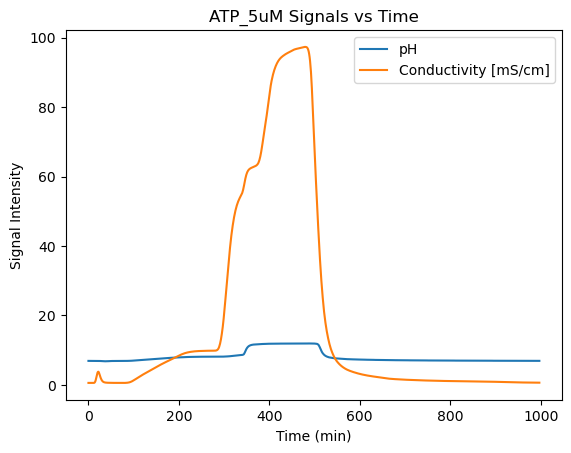

In [38]:
# Plot specific signals vs time
time = sample_dict['Time[min]']

plt.plot(sample_dict['ATP_5uM']['pH'], label='pH')
plt.plot(sample_dict['ATP_5uM']['Conductivity [mS/cm]'], label='Conductivity [mS/cm]')
plt.xlabel('Time (min)')
plt.ylabel('Signal Intensity')
plt.legend()
plt.title('ATP_5uM Signals vs Time')
plt.show()

## Advanced plotting

### Plot the samples and signals of your choice

Available Samples:
['ATP_0.5uM', 'ATP_10uM', 'ATP_1uM', 'ATP_20uM', 'ATP_3uM', 'ATP_5uM', 'Blank ', 'Blank  1', 'Blank  10', 'Blank  11', 'Blank  12', 'Blank  13', 'Blank  14', 'Blank  15', 'Blank  16', 'Blank  2', 'Blank  3', 'Blank  3 rep2', 'Blank  3 rep3', 'Blank  4', 'Blank  4 rep2', 'Blank  5', 'Blank  6', 'Blank  7', 'Blank  8', 'Blank  9', 'CTP_0.5uM', 'CTP_10uM', 'CTP_1uM', 'CTP_20uM', 'CTP_3uM', 'CTP_5uM', 'CleanCap_0.5uM', 'CleanCap_10uM', 'CleanCap_1uM', 'CleanCap_20uM', 'CleanCap_3uM', 'CleanCap_5uM', 'GTP_0.5uM', 'GTP_10uM', 'GTP_1uM', 'GTP_20uM', 'GTP_3uM', 'GTP_5uM', 'SST Sample', 'SST Sample 1', 'UTP:CTP = 30:70_10uM', 'UTP:CTP = 30:70_1uM', 'UTP:CTP = 30:70_20uM', 'UTP:CTP = 30:70_3uM', 'UTP:CTP = 30:70_5uM', 'UTP:CTP = 50:50_10uM', 'UTP:CTP = 50:50_1uM', 'UTP:CTP = 50:50_20uM', 'UTP:CTP = 50:50_3uM', 'UTP:CTP = 50:50_5uM', 'UTP:CTP = 70:30_10uM', 'UTP:CTP = 70:30_1uM', 'UTP:CTP = 70:30_20uM', 'UTP:CTP = 70:30_3uM', 'UTP:CTP = 70:30_5uM', 'UTP_0.5uM', 'UTP_10uM', 'UTP


Enter sample IDs separated by commas (e.g., Sample_1, Sample_2 rep1):  ATP_20uM
Enter signal names separated by commas (e.g., A260 [mAU], A280 [mAU]):  A260 [mAU], Conductivity [mS/cm], pH


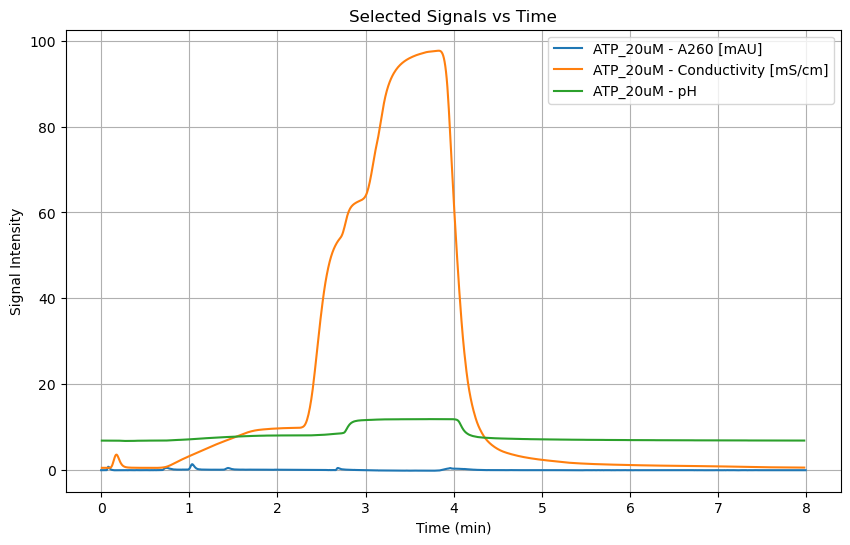


Do you want to save the plot? (y/n):  y


Plot saved successfully to: /Users/zhouy25/Documents/GitHub/projects/dsa/examples/patfix_ht_ds/output/ATP_20uM__A260_mAU_Conductivity_mScm_pH.png


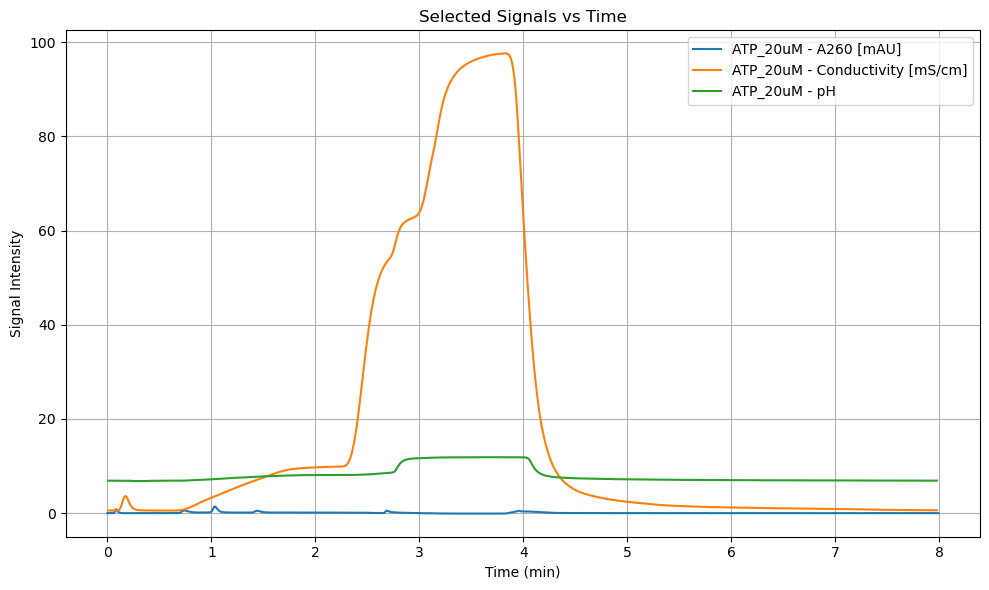

In [40]:
# Step 1: List available samples and signals
all_samples = sorted([k for k in sample_dict.keys() if k != 'Time[min]'])

# Assume all samples have similar signals; pick one to list signals
example_sample = all_samples[0]
all_signals = sorted(list(sample_dict[example_sample].keys()))

print("Available Samples:")
print(all_samples)

print("\nAvailable Signals:")
print(all_signals)

# Step 2: Let user input sample IDs and signals
selected_samples = input("\nEnter sample IDs separated by commas (e.g., Sample_1, Sample_2 rep1): ").split(',')
selected_samples = [s.strip() for s in selected_samples]

selected_signals = input("Enter signal names separated by commas (e.g., A260 [mAU], A280 [mAU]): ").split(',')
selected_signals = [s.strip() for s in selected_signals]

# Step 3: Plot
time = sample_dict['Time[min]']

plt.figure(figsize=(10, 6))

for sample_id in selected_samples:
    for signal_name in selected_signals:
        if sample_id in sample_dict and signal_name in sample_dict[sample_id]:
            plt.plot(time, sample_dict[sample_id][signal_name], label=f'{sample_id} - {signal_name}')
        else:
            print(f"Warning: {sample_id} does not have signal {signal_name}")

plt.xlabel('Time (min)')
plt.ylabel('Signal Intensity')
plt.title('Selected Signals vs Time')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Ask user if they want to save the plot
save_plot = input("\nDo you want to save the plot? (y/n): ").strip().lower()

if save_plot == 'y':
    # Ensure output folder exists
    output_folder = "output"
    cwd = os.getcwd()
    output_path = os.path.join(cwd, output_folder)
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Create a filename based on selections
    sample_part = "_".join([s.replace(" ", "_") for s in selected_samples])
    signal_part = "_".join([s.replace(" ", "_").replace("[", "").replace("]", "").replace("/", "") for s in selected_signals])
    filename = f"{sample_part}__{signal_part}.png"

    file_path = os.path.join(output_path, filename)
    
    # Save figure
    plt.figure(figsize=(10, 6))
    for sample_id in selected_samples:
        for signal_name in selected_signals:
            if sample_id in sample_dict and signal_name in sample_dict[sample_id]:
                plt.plot(time, sample_dict[sample_id][signal_name], label=f'{sample_id} - {signal_name}')
    plt.xlabel('Time (min)')
    plt.ylabel('Signal Intensity')
    plt.title('Selected Signals vs Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig(file_path, dpi=300)
    print(f"Plot saved successfully to: {file_path}")
else:
    print("Plot not saved.")

### Blank substraction

In [293]:
# Step 1: List available samples
all_samples = sorted([k for k in sample_dict.keys() if k != 'Time[min]'])
print("Available Samples:")
print(all_samples)

# Step 2: Ask user to select a blank sample
blank_sample = input("\nEnter the blank sample ID exactly (e.g., Blank, Blank 1): ").strip()

if blank_sample not in sample_dict:
    raise ValueError(f"Selected blank sample '{blank_sample}' not found!")

# Step 3: Initialize new dictionary
subtracted_dict = {}

# Step 4: Subtract blank from all samples, including blank itself
for sample_id in all_samples:
    subtracted_dict[sample_id] = {}  # Always create an entry

    for signal_name in sample_dict[sample_id]:
        if signal_name in sample_dict[blank_sample]:
            if sample_id == blank_sample:
                # For the blank itself, create zero arrays
                corrected_signal = sample_dict[blank_sample][signal_name] * 0
            else:
                corrected_signal = sample_dict[sample_id][signal_name] - sample_dict[blank_sample][signal_name]
            
            subtracted_dict[sample_id][signal_name] = corrected_signal
        else:
            print(f"Warning: Signal {signal_name} missing in blank sample, skipping subtraction for {sample_id}.{signal_name}")

# Step 5: Also keep the Time[min] vector
subtracted_dict['Time[min]'] = sample_dict['Time[min]']

# Step 6: Success message
print(f"\nSubtracted dictionary created successfully with {len(subtracted_dict)-1} samples (excluding Time[min]).")

Available Samples:
['ATP_0.5uM', 'ATP_10uM', 'ATP_1uM', 'ATP_20uM', 'ATP_3uM', 'ATP_5uM', 'Blank ', 'Blank  1', 'Blank  10', 'Blank  11', 'Blank  12', 'Blank  13', 'Blank  14', 'Blank  15', 'Blank  16', 'Blank  2', 'Blank  3', 'Blank  3 rep2', 'Blank  3 rep3', 'Blank  4', 'Blank  4 rep2', 'Blank  5', 'Blank  6', 'Blank  7', 'Blank  8', 'Blank  9', 'CTP_0.5uM', 'CTP_10uM', 'CTP_1uM', 'CTP_20uM', 'CTP_3uM', 'CTP_5uM', 'CleanCap_0.5uM', 'CleanCap_10uM', 'CleanCap_1uM', 'CleanCap_20uM', 'CleanCap_3uM', 'CleanCap_5uM', 'GTP_0.5uM', 'GTP_10uM', 'GTP_1uM', 'GTP_20uM', 'GTP_3uM', 'GTP_5uM', 'SST Sample', 'SST Sample 1', 'UTP:CTP = 30:70_10uM', 'UTP:CTP = 30:70_1uM', 'UTP:CTP = 30:70_20uM', 'UTP:CTP = 30:70_3uM', 'UTP:CTP = 30:70_5uM', 'UTP:CTP = 50:50_10uM', 'UTP:CTP = 50:50_1uM', 'UTP:CTP = 50:50_20uM', 'UTP:CTP = 50:50_3uM', 'UTP:CTP = 50:50_5uM', 'UTP:CTP = 70:30_10uM', 'UTP:CTP = 70:30_1uM', 'UTP:CTP = 70:30_20uM', 'UTP:CTP = 70:30_3uM', 'UTP:CTP = 70:30_5uM', 'UTP_0.5uM', 'UTP_10uM', 'UTP


Enter the blank sample ID exactly (e.g., Blank, Blank 1):  Blank  4 rep2



Subtracted dictionary created successfully with 79 samples (excluding Time[min]).


#### Plot the blank subtracted data - overlap

Available Samples:
['ATP_0.5uM', 'ATP_10uM', 'ATP_1uM', 'ATP_20uM', 'ATP_3uM', 'ATP_5uM', 'Blank ', 'Blank  1', 'Blank  10', 'Blank  11', 'Blank  12', 'Blank  13', 'Blank  14', 'Blank  15', 'Blank  16', 'Blank  2', 'Blank  3', 'Blank  3 rep2', 'Blank  3 rep3', 'Blank  4', 'Blank  4 rep2', 'Blank  5', 'Blank  6', 'Blank  7', 'Blank  8', 'Blank  9', 'CTP_0.5uM', 'CTP_10uM', 'CTP_1uM', 'CTP_20uM', 'CTP_3uM', 'CTP_5uM', 'CleanCap_0.5uM', 'CleanCap_10uM', 'CleanCap_1uM', 'CleanCap_20uM', 'CleanCap_3uM', 'CleanCap_5uM', 'GTP_0.5uM', 'GTP_10uM', 'GTP_1uM', 'GTP_20uM', 'GTP_3uM', 'GTP_5uM', 'SST Sample', 'SST Sample 1', 'UTP:CTP = 30:70_10uM', 'UTP:CTP = 30:70_1uM', 'UTP:CTP = 30:70_20uM', 'UTP:CTP = 30:70_3uM', 'UTP:CTP = 30:70_5uM', 'UTP:CTP = 50:50_10uM', 'UTP:CTP = 50:50_1uM', 'UTP:CTP = 50:50_20uM', 'UTP:CTP = 50:50_3uM', 'UTP:CTP = 50:50_5uM', 'UTP:CTP = 70:30_10uM', 'UTP:CTP = 70:30_1uM', 'UTP:CTP = 70:30_20uM', 'UTP:CTP = 70:30_3uM', 'UTP:CTP = 70:30_5uM', 'UTP_0.5uM', 'UTP_10uM', 'UTP


Enter sample IDs separated by commas (e.g., Sample_1, Sample_2 rep1):  Blank  4 rep2, SST Sample
Enter signal names separated by commas (e.g., A260 [mAU], A280 [mAU]):  A260 [mAU]


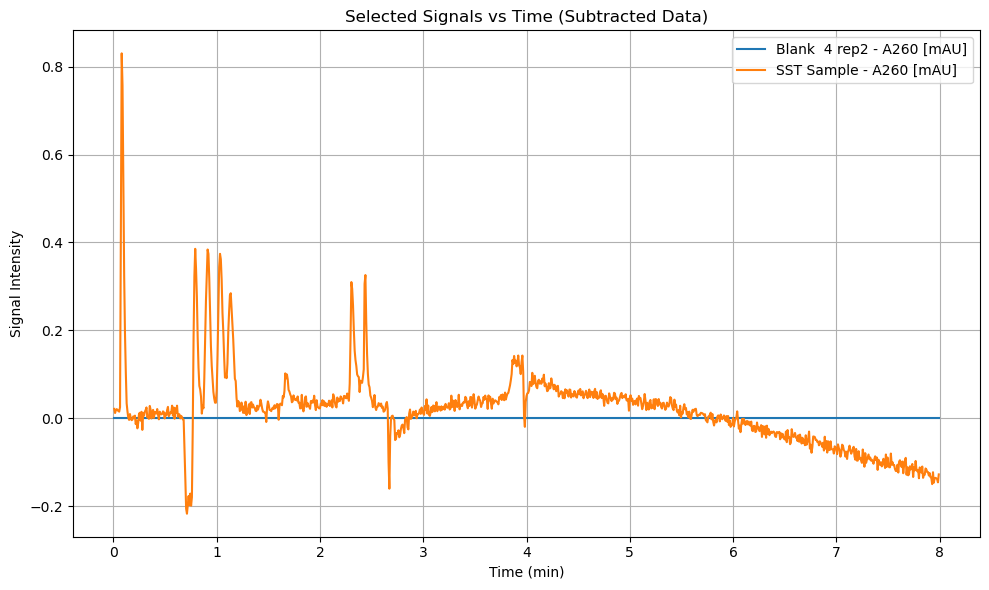


Do you want to save the plot? (y/n):  y


Plot saved successfully to: /Users/zhouy25/Documents/GitHub/projects/dsa/examples/patfix_ht_ds/output/Blank__4_rep2_SST_Sample__A260_mAU_subtracted.png


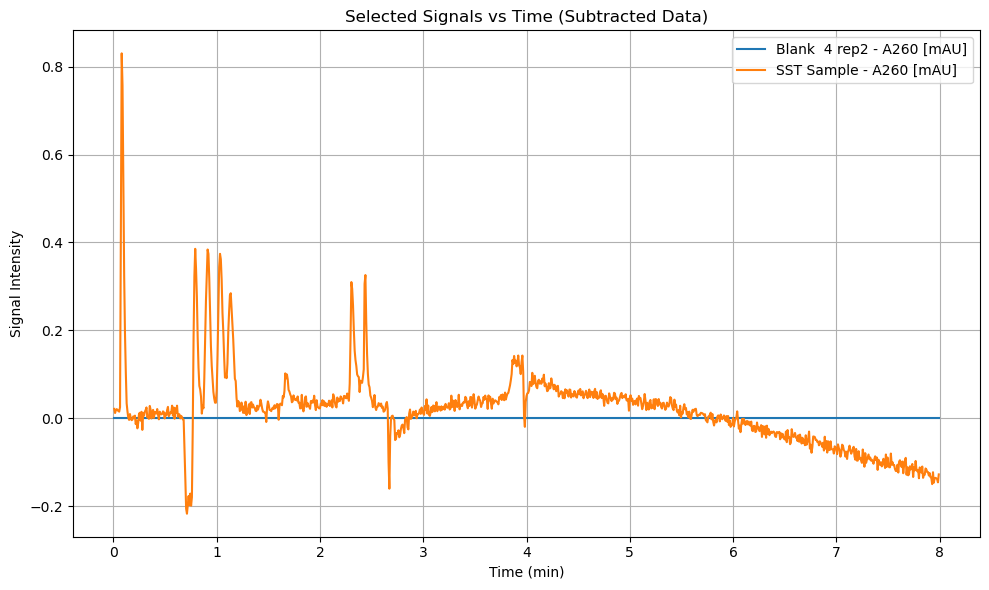

In [295]:
import matplotlib.pyplot as plt
import os

# Step 1: List available samples and signals
all_samples = sorted([k for k in subtracted_dict.keys() if k != 'Time[min]'])

# Pick one sample to list signals
example_sample = all_samples[0]
all_signals = sorted(list(subtracted_dict[example_sample].keys()))

print("Available Samples:")
print(all_samples)

print("\nAvailable Signals:")
print(all_signals)

# Step 2: User input
selected_samples = input("\nEnter sample IDs separated by commas (e.g., Sample_1, Sample_2 rep1): ").split(',')
selected_samples = [s.strip() for s in selected_samples]

selected_signals = input("Enter signal names separated by commas (e.g., A260 [mAU], A280 [mAU]): ").split(',')
selected_signals = [s.strip() for s in selected_signals]

# Step 3: Plot
time = subtracted_dict['Time[min]']  # Time vector from subtracted_dict now

plt.figure(figsize=(10, 6))

for sample_id in selected_samples:
    for signal_name in selected_signals:
        if sample_id in subtracted_dict and signal_name in subtracted_dict[sample_id]:
            plt.plot(time, subtracted_dict[sample_id][signal_name], label=f'{sample_id} - {signal_name}')
        else:
            print(f"Warning: {sample_id} does not have signal {signal_name}")

plt.xlabel('Time (min)')
plt.ylabel('Signal Intensity')
plt.title('Selected Signals vs Time (Subtracted Data)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Ask user if they want to save the plot
save_plot = input("\nDo you want to save the plot? (y/n): ").strip().lower()

if save_plot == 'y':
    # Ensure output folder exists
    output_folder = "output"
    cwd = os.getcwd()
    output_path = os.path.join(cwd, output_folder)
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Create a filename based on selections
    sample_part = "_".join([s.replace(" ", "_") for s in selected_samples])
    signal_part = "_".join([s.replace(" ", "_").replace("[", "").replace("]", "").replace("/", "") for s in selected_signals])
    filename = f"{sample_part}__{signal_part}_subtracted.png"

    file_path = os.path.join(output_path, filename)
    
    # Save figure
    plt.figure(figsize=(10, 6))
    for sample_id in selected_samples:
        for signal_name in selected_signals:
            if sample_id in subtracted_dict and signal_name in subtracted_dict[sample_id]:
                plt.plot(time, subtracted_dict[sample_id][signal_name], label=f'{sample_id} - {signal_name}')
    plt.xlabel('Time (min)')
    plt.ylabel('Signal Intensity')
    plt.title('Selected Signals vs Time (Subtracted Data)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig(file_path, dpi=300)
    print(f"Plot saved successfully to: {file_path}")
else:
    print("Plot not saved.")

#### Plot the blank subtracted data - aligned

Available Samples:
['ATP_0.5uM', 'ATP_10uM', 'ATP_1uM', 'ATP_20uM', 'ATP_3uM', 'ATP_5uM', 'Blank ', 'Blank  1', 'Blank  10', 'Blank  11', 'Blank  12', 'Blank  13', 'Blank  14', 'Blank  15', 'Blank  16', 'Blank  2', 'Blank  3', 'Blank  3 rep2', 'Blank  3 rep3', 'Blank  4', 'Blank  4 rep2', 'Blank  5', 'Blank  6', 'Blank  7', 'Blank  8', 'Blank  9', 'CTP_0.5uM', 'CTP_10uM', 'CTP_1uM', 'CTP_20uM', 'CTP_3uM', 'CTP_5uM', 'CleanCap_0.5uM', 'CleanCap_10uM', 'CleanCap_1uM', 'CleanCap_20uM', 'CleanCap_3uM', 'CleanCap_5uM', 'GTP_0.5uM', 'GTP_10uM', 'GTP_1uM', 'GTP_20uM', 'GTP_3uM', 'GTP_5uM', 'SST Sample', 'SST Sample 1', 'UTP:CTP = 30:70_10uM', 'UTP:CTP = 30:70_1uM', 'UTP:CTP = 30:70_20uM', 'UTP:CTP = 30:70_3uM', 'UTP:CTP = 30:70_5uM', 'UTP:CTP = 50:50_10uM', 'UTP:CTP = 50:50_1uM', 'UTP:CTP = 50:50_20uM', 'UTP:CTP = 50:50_3uM', 'UTP:CTP = 50:50_5uM', 'UTP:CTP = 70:30_10uM', 'UTP:CTP = 70:30_1uM', 'UTP:CTP = 70:30_20uM', 'UTP:CTP = 70:30_3uM', 'UTP:CTP = 70:30_5uM', 'UTP_0.5uM', 'UTP_10uM', 'UTP


Enter sample IDs separated by commas (e.g., Sample_1, Sample_2 rep1):  SST Sample, SST Sample 1, ATP_10uM, UTP_10uM, CTP_10uM, GTP_10uM
Enter signal names separated by commas (e.g., A260 [mAU], A280 [mAU]):  A260 [mAU]


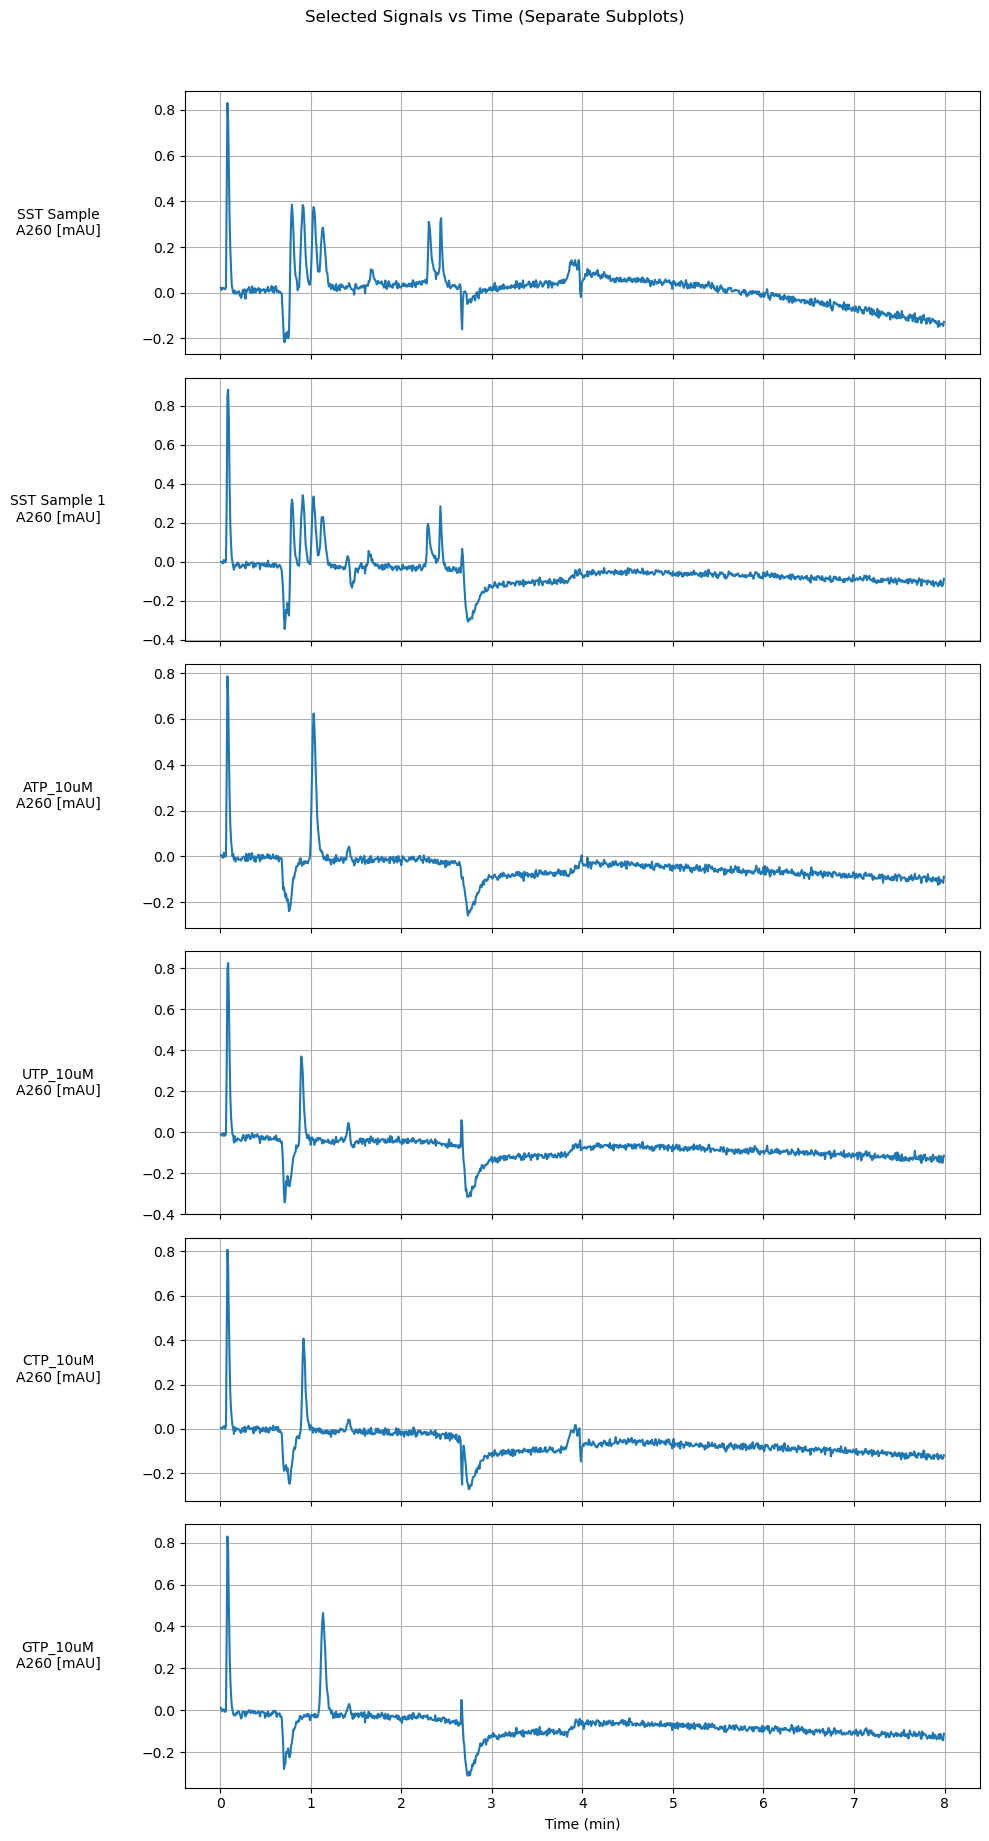


Do you want to save the aligned plot? (y/n):  y

Enter a prefix for the plot filename (leave blank for none):  SST_NTPs


Plot saved successfully to: /Users/zhouy25/Documents/GitHub/projects/dsa/examples/patfix_ht_ds/output/SST_NTPs_A260_mAU_aligned.png


In [317]:
import matplotlib.pyplot as plt
import os

# Step 1: List available samples and signals
all_samples = sorted([k for k in subtracted_dict.keys() if k != 'Time[min]'])

# Pick one sample to list signals
example_sample = all_samples[0]
all_signals = sorted(list(subtracted_dict[example_sample].keys()))

print("Available Samples:")
print(all_samples)

print("\nAvailable Signals:")
print(all_signals)

# Step 2: User input
selected_samples = input("\nEnter sample IDs separated by commas (e.g., Sample_1, Sample_2 rep1): ").split(',')
selected_samples = [s.strip() for s in selected_samples]

selected_signals = input("Enter signal names separated by commas (e.g., A260 [mAU], A280 [mAU]): ").split(',')
selected_signals = [s.strip() for s in selected_signals]

# Step 3: Prepare time vector
time = subtracted_dict['Time[min]']

# Step 4: Setup subplots
total_plots = len(selected_samples) * len(selected_signals)

fig, axes = plt.subplots(total_plots, 1, figsize=(10, 3 * total_plots), sharex=True)

# If there's only one subplot, make it a list
if total_plots == 1:
    axes = [axes]

# Step 5: Plot each sample-signal in its own subplot
plot_idx = 0
for sample_id in selected_samples:
    for signal_name in selected_signals:
        if sample_id in subtracted_dict and signal_name in subtracted_dict[sample_id]:
            axes[plot_idx].plot(time, subtracted_dict[sample_id][signal_name])
            axes[plot_idx].set_ylabel(f'{sample_id}\n{signal_name}', rotation=0, labelpad=60, va='center')
            axes[plot_idx].grid(True)
            plot_idx += 1
        else:
            print(f"Warning: {sample_id} does not have signal {signal_name}")

# Common x-axis label
axes[-1].set_xlabel('Time (min)')

plt.suptitle('Selected Signals vs Time (Separate Subplots)', y=1.02)
plt.tight_layout()
plt.show()

# Step 6: Ask if want to save
save_plot = input("\nDo you want to save the aligned plot? (y/n): ").strip().lower()

if save_plot == 'y':
    # Ensure output folder exists
    output_folder = "output"
    cwd = os.getcwd()
    output_path = os.path.join(cwd, output_folder)
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Create a filename
    # Ask user for a custom prefix
    prefix = input("\nEnter a prefix for the plot filename (leave blank for none): ").strip()

    # Generate the signal part from selected signals
    signal_part = "_".join([s.replace(" ", "_").replace("[", "").replace("]", "").replace("/", "") for s in selected_signals])

    # Build filename based on whether prefix is given
    if prefix:
        filename = f"{prefix}_{signal_part}_aligned.png"
    else:
        filename = f"{signal_part}_aligned.png"
    
    file_path = os.path.join(output_path, filename)
    
    # Save figure
    fig.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved successfully to: {file_path}")
else:
    print("Plot not saved.")